In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [10]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Base.classes.keys()

['measurement', 'station']

In [12]:
# View all of the classes that automap found
Station=Base.classes.station
Measurement=Base.classes.measurement
session=Session(engine)
inspector=inspect(engine)

In [13]:
# Save references to each table
stations=engine.execute('Select * FROM Station')
print(stations.keys())

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


In [14]:
# Create our session (link) from Python to the DB
session=Session(engine)
inspector=inspect(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [15]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
start_date='2017-08-01'
end_date='2017-08-10'

def calc_temps(start_date, end_date):
    
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-08-01', '2012-08-10'))

[(65.0, 74.640625, 82.0)]


In [20]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
start_date='2017-01-01'
end_date='2017-12-31'

def calc_temps(start_date, end_date):
    
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
trip_temp=calc_temps(start_date,end_date)

# For example
print(calc_temps('2012-01-01', '2012-12-31'))

[(56.0, 72.26401515151515, 86.0)]


In [21]:
tavg = [int(result[1]) for result in trip_temp[::]]
tavg

[74]

In [22]:
tmax_tmin=(session.query(func.max(Measurement.tobs) - func.min(Measurement.tobs))
                  .filter(Measurement.date >= start_date)
                  .filter(Measurement.date <= end_date)
                  .all())
    
ptp=list(np.ravel(tmax_tmin))
ptp

[29.0]

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

tick_locations  = [value for value in x_axis]

plt.bar(x_axis, tavg, yerr=ptp[0])
plt.xticks(tick_locations, [(f'From {start_date} To {end_date}')]
plt.title('Trip Avg Temp')
plt.ylabel('Temperature (F)')
plt.yticks
plt.xlim(-0.1,0.1)
plt.ylim(-5,100)
           
plt.show()

SyntaxError: invalid syntax (<ipython-input-30-dd754a67d1ca>, line 10)

### Daily Rainfall Average

In [35]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

Total_Precip_by_st=(session.query(Measurement.station,Station.name,func.sum(Measurement.prcp),
                                Station.latitude,Station.longitude,Station.elevation)
                         .filter(Measurement.date >= start_date)
                         .filter(Measurement.date <= end_date)
                         .filter(Measurement.station == Station.station)
                         .group_by(Measurement.station)
                         .order_by(func.sum(Measurement.prcp)
                         .desc())
                         .all())

In [42]:
print(f'Daily Rainfall by Station for {start_date} to {end_date}.')

Total_Precip_by_st_df=pd.DataFrame(Total_Precip_by_st,
                                 columns=['Station','Name', 'Total Precipitation',
                                          'Latitude',
                                          'Longitude','Elevation'])
Total_Precip_by_st_df

Daily Rainfall by Station for 2017-08-01 to 2017-08-10.


,Station,Name,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.92,21.33310,-157.80250,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.32,21.52130,-157.83740,7.0
2,USC00519281,"WAIHEE 837.5, HI US",0.06,21.45167,-157.84889,32.9
3,USC00519397,"WAIKIKI 717.2, HI US",0.04,21.27160,-157.81680,3.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.00,21.33556,-157.71139,19.5


In [43]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [45]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
# Strip off the year and save a list of strings in the format %m-%d
Trip_Dates=['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07']
Normals=[]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
def Daily_Normals(date):
    sel = [func.min(Measurement.tobs),
          func.round(func.avg(Measurement.tobs),2),
          func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
for i in Trip_Dates:
    Normals.append(Daily_Normals(i)[0])
Normals

[(67.0, 75.54, 83.0),
 (68.0, 75.6, 84.0),
 (70.0, 76.61, 85.0),
 (69.0, 76.71, 84.0),
 (69.0, 76.15, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.16, 83.0)]

In [46]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Trip_Dates_Daily_Normals_df=pd.DataFrame(Normals, columns=['Minimum Temp', 'Average Temp', "Maximum Temp"],
                                        index=Trip_Dates)

Trip_Dates_Daily_Normals_df.index.name='Date'
Trip_Dates_Daily_Normals_df

,Minimum Temp,Average Temp,Maximum Temp
Date,,,
08-01,67.0,75.54,83.0
08-02,68.0,75.60,84.0
08-03,70.0,76.61,85.0
08-04,69.0,76.71,84.0
08-05,69.0,76.15,82.0
08-06,67.0,76.25,83.0
08-07,71.0,77.16,83.0


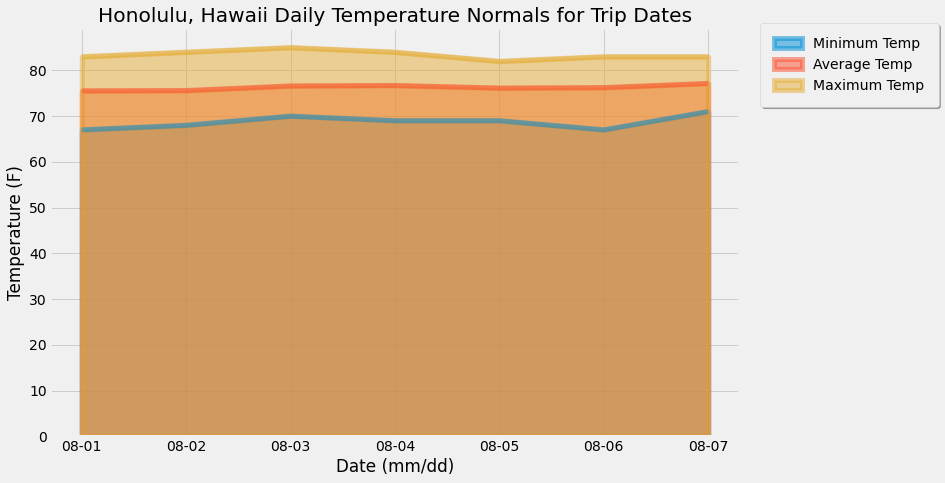

In [53]:
# Plot the daily normals as an area plot with `stacked=False`

Trip_Dates_Daily_Normals_df.plot.area(linewidth=5, stacked=False);
plt.xlabel('Date (mm/dd)')
plt.ylabel('Temperature (F)')
plt.title("Honolulu, Hawaii Daily Temperature Normals for Trip Dates")
plt.gca().legend(loc='center left', bbox_to_anchor=(1.02, 0.91),shadow=True,borderpad=1);

## Close Session